# Detecção de anomalias em um sistema de distribuição de água

Este *notebook* é destinado à apresentação de uma solução baseada em aprendizado de máquina e ciência de dados para a detecção de anomalias em um sistema de distribuição de água. Para tanto, será utilizado o conjunto de dados aberto denominado *Pump Sensor Data*, disponível neste [*link*](https://www.kaggle.com/nphantawee/pump-sensor-data).

O conjunto de dados em questão possui registros temporais da instrumentação de um sistema de bombeamento de água. Os dados foram colhidos durante um ano, período no qual ocorreram 7 falhas. Dessa maneira, espera-se que seja possível identificar, por meio dos sinais dos sensores, padrões que indiquem as anomalias causadas pelas falhas supracitadas.

Por meio do problema apresentado, o real objetivo deste *notebook* é apresentar uma metodologia simples para se lidar com problemas relacionados à área de ciência de dados e aprendizado de máquina, como uma forma de introdução aos temas. Ao longo dos tópicos abordados a seguir, serão apresentados conceitos básicos e fundamentais das áreas em questão.

# Importações

In [1]:
# ferramentas matemáticas
import numpy as np
import pandas as pd

# ferramentas gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# ferramentas de aprendizado de máquina
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# utilitários
from pump_utils import process, plots, models

# Importação dos dados

In [2]:
# importação dos dados
path = './datasets/sensor.csv'
data = pd.read_csv(path, index_col=0)

# Análise Exploratória dos Dados

A análise exploratória dos dados (*exploratory data analysis - EDA*) é uma etapa crucial no desenvolvimento de um problema de ciência de dados. Nela, o cientista de dados vai conhecer o conjunto trabalhado, entender suas características, bem como criar e testar hipóteses relacionadas ao problema a ser resolvido. É justamente na EDA que os *insights* para a solução do problema surgem e, muitas vezes, pode-se cumprir o objetivo do trabalho nessa etapa.

No caso do *Pump Sensor Data*, não se tem quase nenhuma informação sobre os dados, além dos fatos já citados na introdução deste *notebook*. Isso faz com que a EDA se torne ainda mais importante, uma vez que toda a identificação do conjunto de dados se dará nessa etapa.

In [3]:
# visualização tabular
data.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


Por meio da visualização tabular dos dados, pode-se verificar que esse conjunto possui colunas referentes aos sensores, já citados, além de uma coluna "timestamp", que contém uma informação temporal, e uma coluna "machine_status", que, aparentemente, indica a situação operacional do sistema.

In [4]:
# descritivo dos dados
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       210112 non-null  float64
 2   sensor_01       219951 non-null  float64
 3   sensor_02       220301 non-null  float64
 4   sensor_03       220301 non-null  float64
 5   sensor_04       220301 non-null  float64
 6   sensor_05       220301 non-null  float64
 7   sensor_06       215522 non-null  float64
 8   sensor_07       214869 non-null  float64
 9   sensor_08       215213 non-null  float64
 10  sensor_09       215725 non-null  float64
 11  sensor_10       220301 non-null  float64
 12  sensor_11       220301 non-null  float64
 13  sensor_12       220301 non-null  float64
 14  sensor_13       220301 non-null  float64
 15  sensor_14       220299 non-null  float64
 16  sensor_15       0 non-null       float64
 17  sensor_16 

A visualização do descritivo do conjunto, por sua vez, mostra que, dentre os sensores, o sensor 15 é completamente nulo e, portanto, não será útil para a análise. Ademais, verifica-se que, embora se tenha 52 sensores (a contagem inicia do 0), não há a indicação dos tipos de sensores ou das variáveis medidas por eles. A ausência dessa informação inviabiliza o uso de conhecimento de causa para as análises posteriores, o que diminui a interpretação do problema e a criação de hipóteses.

<AxesSubplot:xlabel='machine_status', ylabel='count'>

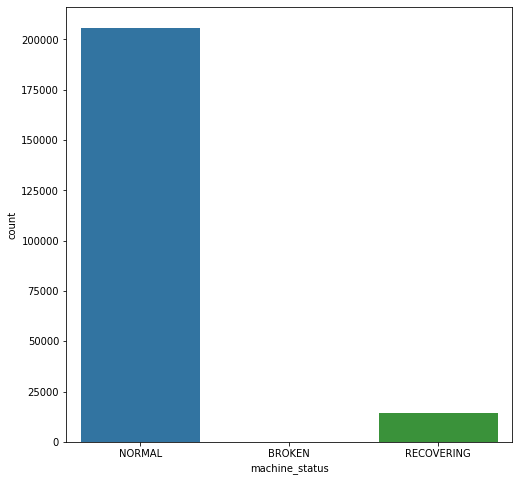

In [5]:
# verificação da cardinalidade da coluna "machine_status"
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(data=data, x='machine_status', ax=ax)

Por meio do gráfico de contagem exposto acima, pode-se verificar que existem três possíveis rótulos para a variável "machine_status": *normal*, *broken* e *recovering*. Cria-se a expectativa, por meio do nome dos rótulos, que a condição *normal* indique uma situação regular de operação do sistema de bombeamento, a condição *broken* denote o momento da falha do sistema e que a condição *recovering* indique uma situação de recuperação do sistema. 

Além disso, pode-se verificar que as supostas condições de operação possuem cardinalidades diferentes. Observa-se muito mais casos supostamente normais do que supostamente anormais (*broken* e *recovering*). Essa condição de desbalanceamento no conjunto de dados é muito comum em problemas relacionados ao monitoramento de condição de sistemas, uma vez que se espera que eles operem sob condições normais a maior parte do tempo.

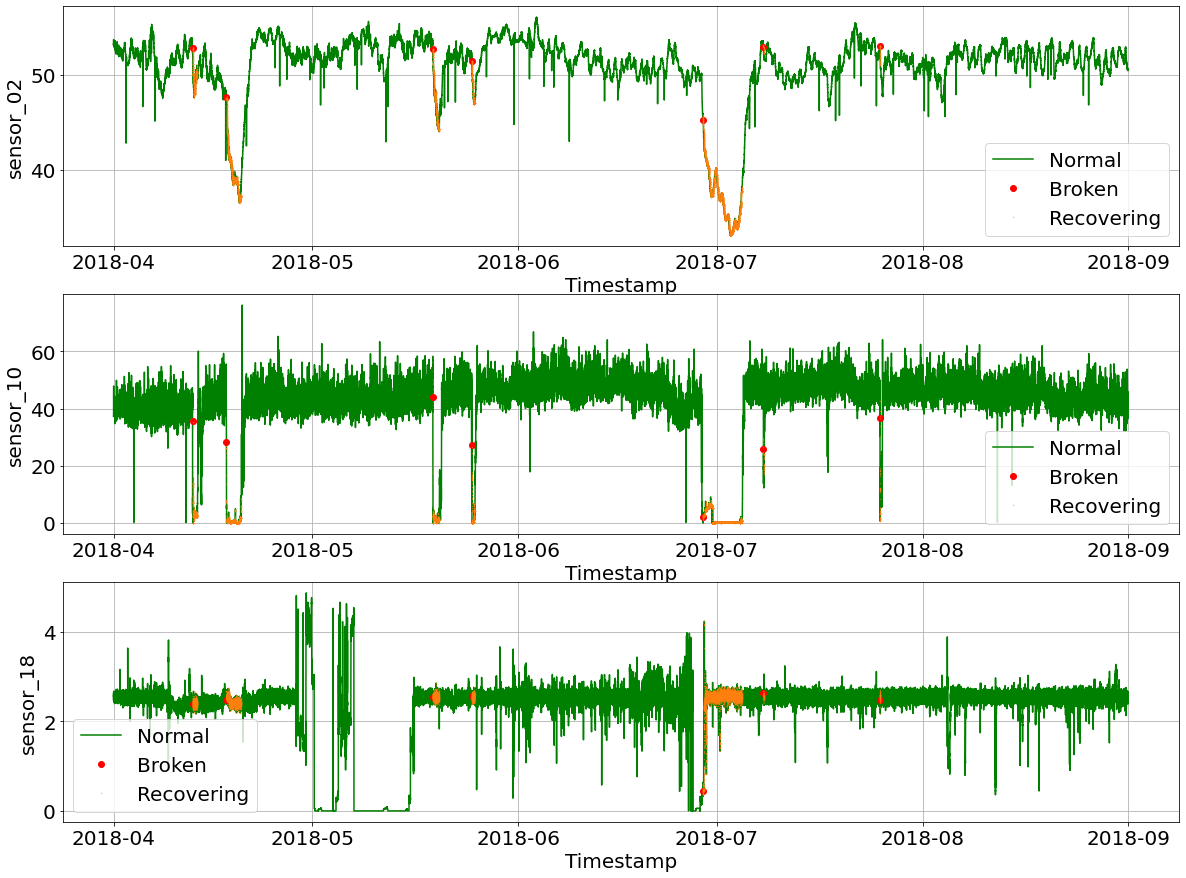

In [6]:
# mudança no formato da coluna "timestamp"
data['timestamp'] = data['timestamp'].astype('datetime64')

# visualização temporal dos dados
plots.sensor_plot(data, sensors=[f'sensor_{i}' for i in ['02', '10', '18']])

A visualização temporal dos sensores indica uma confirmação da hipótese sobre o significado dos rótulos da variável "machine_status" criada anteriormente. Aparentemente, o rótulo *broken* indica o momento da falha, enquanto o rótulo *recovering* se refere ao momento em que o sistema está se recuperando da falha para, posteriormente, atingir o patamar de funcionamento desejado. Como critério de análise, inicialmente, as situações de *recovering* e *broken* serão consideradas anômalas.

Dentre os comportamentos temporais dos sensores, pode-se verificar que alguns destes, tais como o sensor 02, apresentam um crescimento na amplitude do sinal nos momentos em que foram verificadas anomalias no sistema. Em outros sensores, como o sensor 10, as anomalias ocorreram quando o sinal assumiu um valor nulo, apresentando, assim, um pico referente à sua amplitude. Por último, ainda há sinais que não apresentaram nenhuma relação clara entre o seu sinal e a ocorrência de falha, como mostra o sensor 18.

In [7]:
# binarização da variável "machine_status"
data['b_machine_status'] = data['machine_status'].apply(lambda x: x if x == 'NORMAL' else 'ANOMALY')

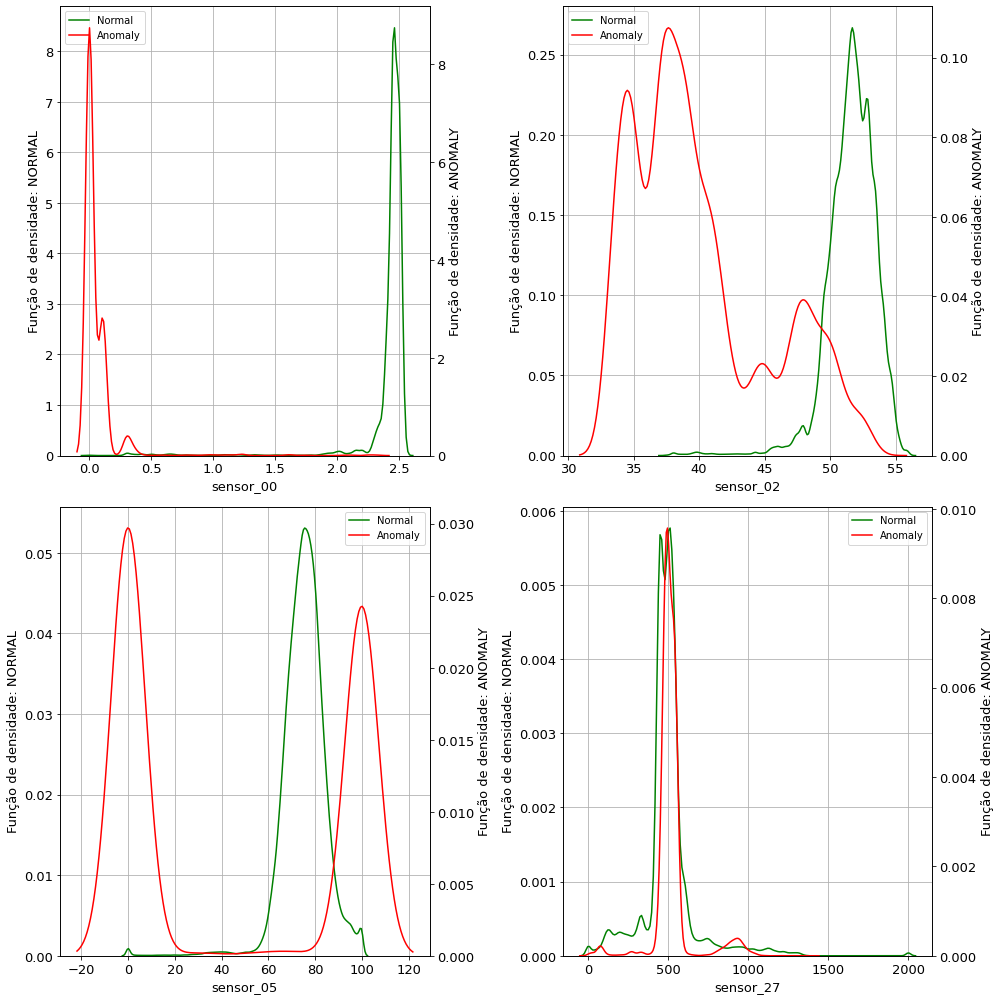

In [8]:
# verificação das distribuições dos sensores
plots.dist_plot(data, sensors=[f'sensor_{i}' for i in ['00', '02', '05', '27']])

A análise da distribuição das variáveis por meio de histogramas ou funções de densidade é uma ótima ferramenta para verificar o comportamento dessas *features* em relação à variável alvo. Para um problema de classificação, como o abordado por esse *notebook*, é interessante verificar se alguma variável apresenta distribuições distintas entre os possíveis rótulos. Essa distinção indica uma boa correlação, uma vez que há uma variação clara de seus valores em relação às condições existentes.

Quando analisadas as distribuições dos sensores, pode-se verificar que alguns deles, tais como os sensores 0 e 2, possuem uma boa distinção entre as condições normais e anômalas. No que tange ao sensor 2, pode-se verificar, ainda, uma certa interseção entre as distribuições, o que não ocorre no sensor 0. No sensor 5, por outro lado, apesar de haver uma diferença entre as distribuições, a correlação entre essa variável e a condição do sistema indica uma possível não linearidade. O sensor 27 e os sensores similares apresentam uma grande interseção entre as distribuições, indicando uma possível baixa correlação entre as variáveis.

No que concerne às variáveis com indicação de boas correlações, de modo geral, pode-se citar os sensores: 0, 1, 2, 3, 4, 5, 10, 11, 12, 48, 50, 51.

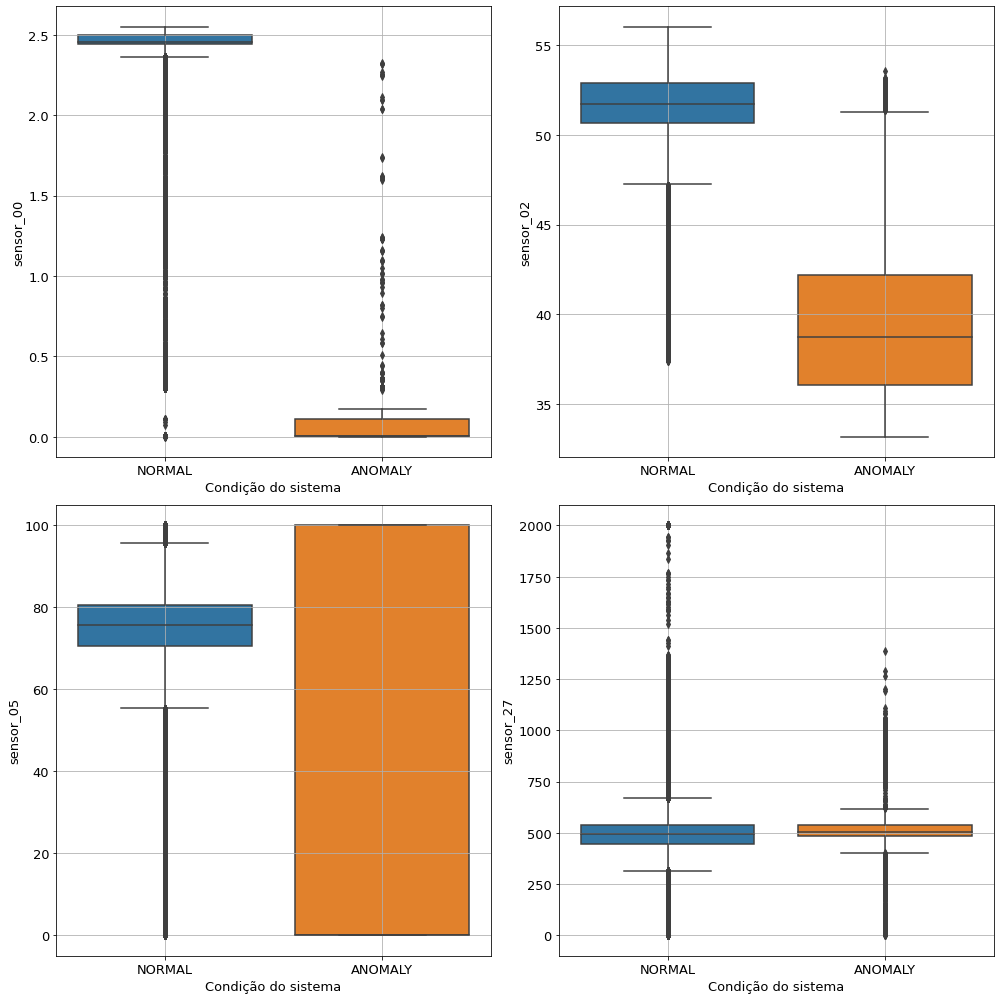

In [9]:
# verificação dos boxplots dos sensores
plots.boxplot(data, sensors=[f'sensor_{i}' for i in ['00', '02', '05', '27']])

Uma outra forma de verificar a distribuição das variáveis em relação à variável *target* se dá por meio dos diagramas de blocos, ou *boxplots*. Nesse tipo de gráfico, a distribuição é representada pelo intervalo interquartil (retângulo azul ou laranja no gráfico acima), pelos valores máximos e mínimos confiáveis (barras horizontais) e pelos *outliers* (pontos). O intervalo interquartil (IQR) representa o conjunto de valores contidos entre o primeiro e o terceiro quartil. Os *outliers*, por padrão, são todos os pontos que excedem 1,5 vezes o valor do IQR.

Das variáveis apresentadas, e já citadas, confirma-se a característica anteriormente observada quanto aos sensores 0 e 2. Essas variáveis apresentam IQR muito distintos para as situações normais e anômalas. Além disso, há uma indicação de que as situações anômalas apresentem valores considerados *outliers* pela situação normal. Esse fato pode indicar uma boa performance de modelos de aprendizado não supervisionado que identificam valores anômalos no conjunto de dados, tais como *Isolation Forest* ou *DBSCAN*.

No que tange ao sensor 5, a possível não linearidade observada apresenta-se na forma de um IQR muito largo, indicando, mais uma vez, que essa variável não apresenta uma correspondência direta com a condição do sistema. A variável 27, por sua vez, apresenta uma distribuição muito similar entre as condições possíveis, como já visto. Note que os padrões discutidos são observados nas demais variáveis.


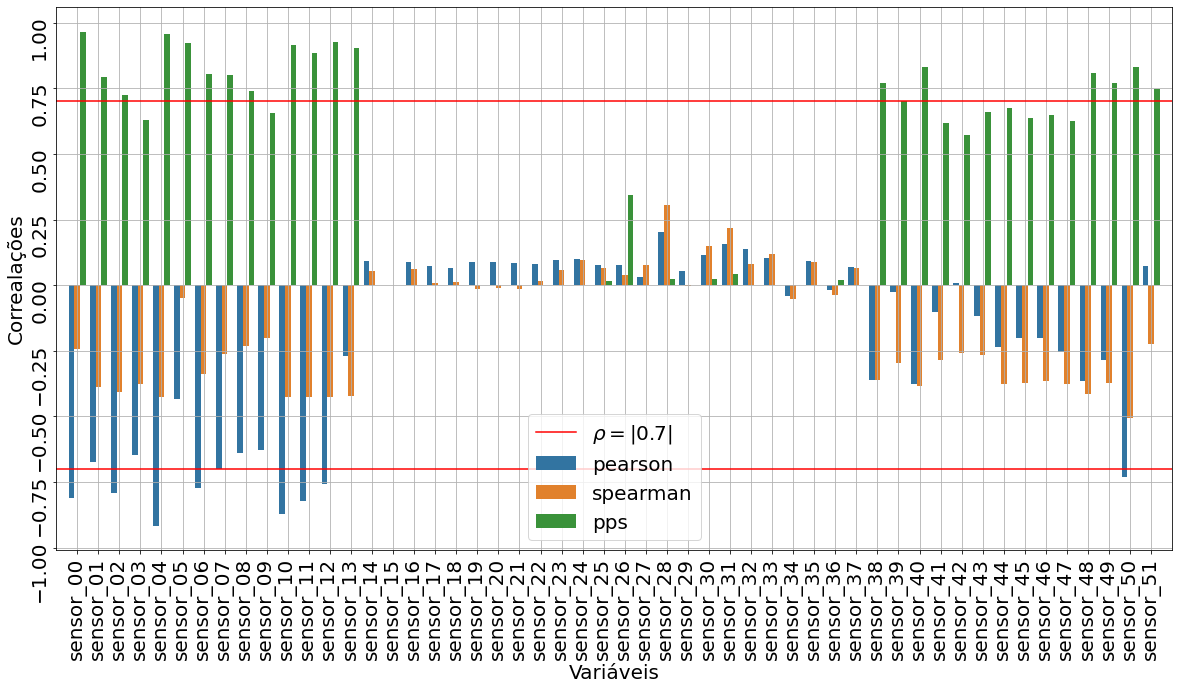

In [10]:
# verificação das correlações bivariadas entre os sensores e a variável "machine_status"
plots.corr_plot(data, th=.7)

Uma forma quantitativa de verificar as correlações bivariadas entre as variáveis e a variável alvo se dá por meio da utilização das métricas de Pearson, Spearman e *Predictive Power Score* (PPS). A correlação de Pearson, determinada por meio da equação abaixo, indica a correlação linear entre duas variáveis. A correlação de Spearman, por sua vez, cuja função também está representada abaixo, indica uma correlação monotônica, que, embora seja não linear, apresenta uma correspondência entre os crescimentos ou decrescimentos das variáveis (pode-se pensar em derivadas) e, por isso, não consegue representar toda forma de não linearidade.

> $pearson=\dfrac{cov(x,y)}{\sigma(x)\cdot \sigma(y)}$

> $spearman = \dfrac{cov(rg_x,rg_y)}{\sigma(rg_x)\cdot \sigma(rg_y)}$

A métrica PPS, por outro lado, utiliza um modelo de Árvore de Decisão para prever uma variável tendo uma outra como entrada. Dessa forma, uma vez que o modelo de aprendizado de máquina utilizado é capaz de realizar um mapeamento não linear das *features*, o PPS é capaz de indicar correlações não lineares. Vale ressaltar, todavia, que se deve fazer uso dessa ferramenta com parcimônia, uma vez que ela está sujeita a problemas comuns encontrados durante o treinamento de modelos de *machine learning*. Por esse motivo, é indicada leitura de sua documentação, que pode ser acessada por esse [link](https://github.com/8080labs/ppscore).

Por meio do gráfico de correlações apresentado acima, pode-se verificar que as variáveis que apresentaram uma boa expectativa quanto à correlação foram confirmadas quantitativamente por meio das técnicas de Pearson, Spearman e PPS. Utilizando um *threshold* de 0,7 para as correlações, em módulo, pode-se elencar os sensores que apresentaram maior correlação com os momentos de anomalia: 0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 38, 40, 48, 49, 50 e 51.

![corr](./img/corr.png)

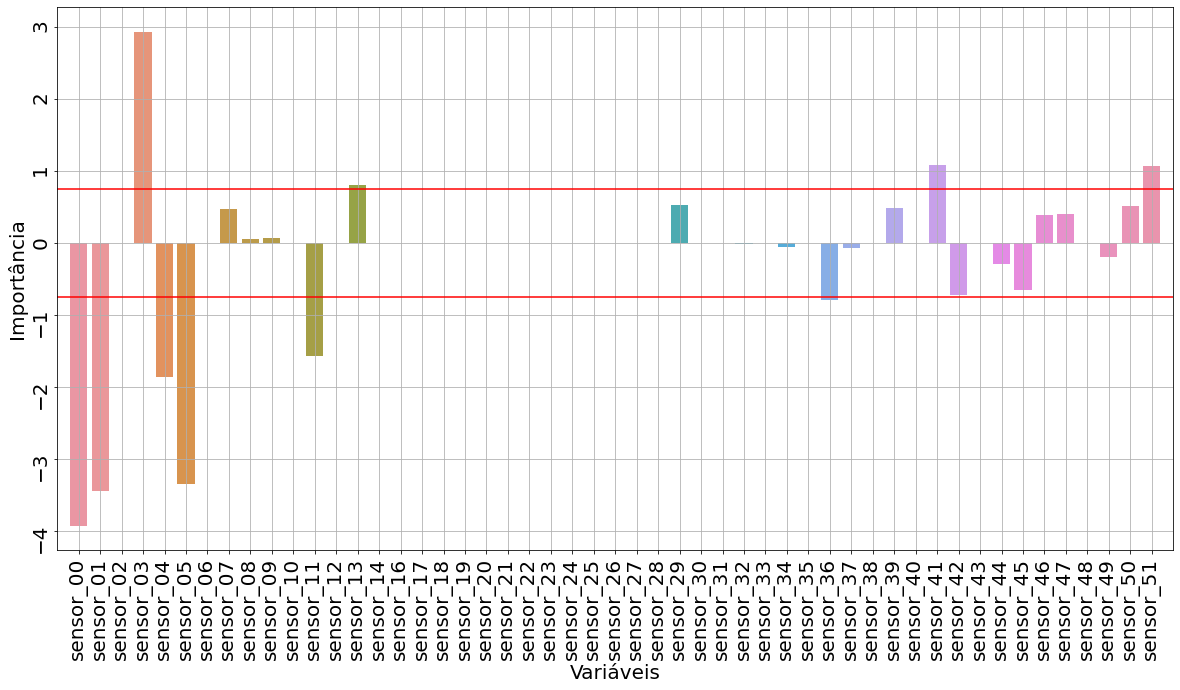

In [11]:
# verificação da correlação multivariada
plots.mvar_corr(data, th=.75)

Embora as correlações observadas até então forneçam muita informação sobre o comportamento entre as *features* e a variável alvo, essas correlações bivariadas não são capazes de descrever como as variáveis se comportam em conjunto em relação ao *target*. A esse comportamento conjunto se dá o nome de correlação multivariada.

Existem algumas técnicas que podem indicar esse tipo de correlação, dentre elas, a regressão logística (ou linear, para o caso em um problema de regressão) com regularização Lasso. O princípio de funcionamento é simples: treina-se um modelo de regressão logística com regularização $l1$ para prever a variável alvo por meio das variáveis dependentes, cuja correlação é desejada.

> $l_1 = \alpha \sum _{j=1}^{n} |w_j|$

O modelo de aprendizado realizará um mapeamento entre as variáveis de entrada e saída durante o treinamento, enquanto a penalidade $l1$ atribuirá o valor 0 às variáveis julgadas pouco importantes durante essa etapa. Após o treinamento, verifica-se quais foram as *features* mais relevantes à predição. Essas, por sua vez, apresentam uma correlação multivariada com o alvo, ou seja, elas, em conjunto, são capazes de prever relativamente bem a variável desejada.

No problema tratado até então, observa-se que os sensores 0, 1, 3, 4, 5, 10, 11, 45, 48 e 51 indicam uma boa correlação multivariada com "machine_status". Note que, dentre os sensores citados, há alguns que não apresentavam boa correlação bivariada, tais como o sensor 3, indicando que essa *feature* não seria capaz de prever a variável alvo sozinha, embora possuísse informações relevantes quando usada em conjunto com outras.

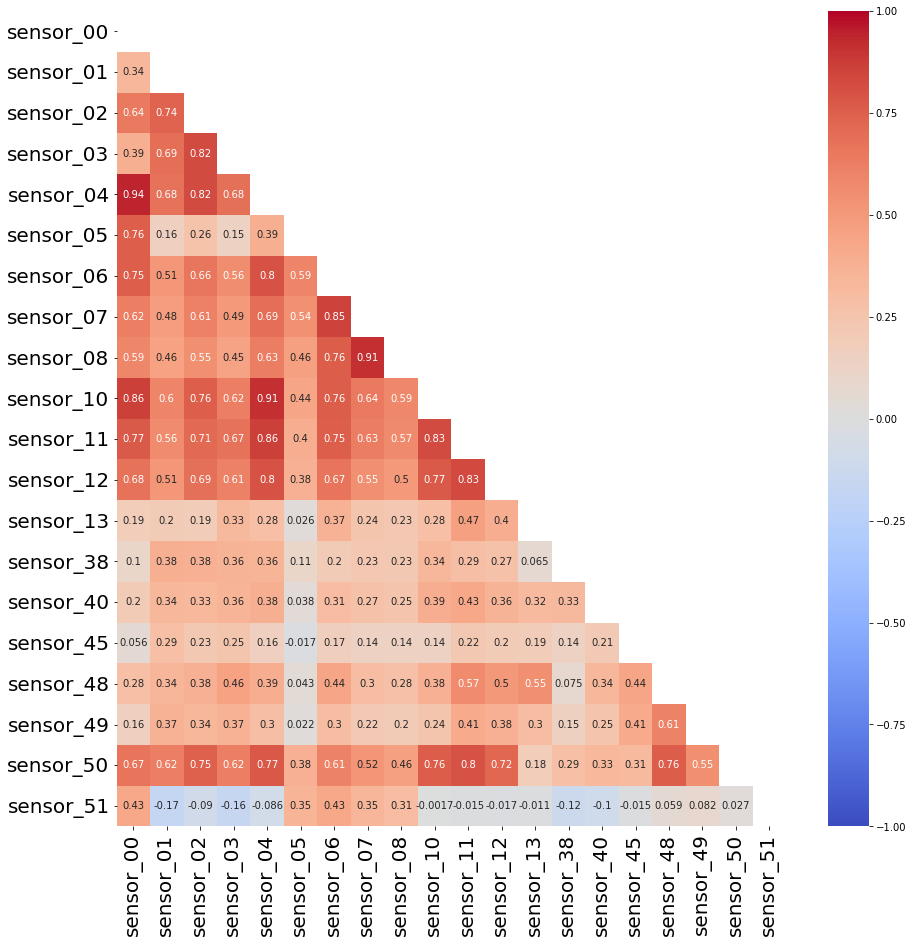

In [12]:
# verificação das variáveis redundantes
num_sensors = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '10', '11', '12', '13', '38', '40', '45', '48', '49', '50', '51']
selected_sensors = [f'sensor_{i}' for i in num_sensors]
plots.redundant_features(data, sensors=selected_sensors)

O mapa de calor plotado acima indica as correlações de Pearson entre as variáveis selecionadas até então. Uma alta correlação indica uma redundância entre as variáveis, ou seja, uma consegue explicar a outra. A presença de redundância em modelos de aprendizado de máquina é prejudicial ao treinamento, uma vez que ela atrasa a etapa de treinamento e, consequentemente, provoca um aumento da demanda computacional.

Para um limite arbitrário de 0.95, verifica-se que nenhuma variável selecionada apresenta redundância. Todavia, os sensores 00 e 04 possuem uma correlação de Pearson de 0.94, o que indica que, caso haja necessidade, a exclusão de uma dessas duas variáveis não implicaria muita perda de informação. *A priori*, opta-se por não excluir nenhuma variável selecionada.

# Pré processamento dos dados

O pré processamento dos dados se refere à etapa em que há a organização, limpeza e tratamento do conjunto de dados, ações importantes durante o preparo do *dataset* para a aplicação de um modelo de aprendizado de máquina. No que tange ao tratamento dos dados, uma das tarefas mais recorrentes é lidar com os dados faltantes do conjunto, tendo em vista que a maior parte dos modelos de *machine learning* não consegue lidar com essa carência de informação. A ausência de dados é algo comum e pode decorrer de diversos motivos, tais como a falta de preenchimento de um formulário, um erro no registro de um sensor etc.

Pode-se lidar com a falta de dados de algumas maneiras. Em geral, procede-se com a exclusão dos dados ou com a inserção de dados artificiais. Embora a primeira opção seja mais conservadora, retirar linhas ou colunas pode implicar em uma diminuição brusca do conjunto de dados, o que, por sua vez, pode prejudicar a performance dos modelos de aprendizado de máquina. O acréscimo de dados artificiais, por outro lado, deve ser feito com cuidado para que as características das variáveis não sejam mudadas.

No que concerne ao preenchimento de dados faltantes, muitas técnicas podem ser usadas e, portanto, a metodologia escolhida deve levar em conta o problema e o conjunto de dados trabalhado. Pode-se usar técnicas mais avançadas, como o *Synthetic Minority Oversampling Technique* (SMOTE), ou simples substituições por métricas estatísticas, tais como média ou moda. Como os dados do *Pump Sensor Data* possuem correspondência física e correlações temporais, pode-se lançar mão de uma interpolação linear para lidar com o problema discutido.

In [13]:
null_list = data.isnull().sum()
(null_list[null_list != 0] / data.shape[0])*100

sensor_00      4.633261
sensor_01      0.167484
sensor_02      0.008624
sensor_03      0.008624
sensor_04      0.008624
sensor_05      0.008624
sensor_06      2.177741
sensor_07      2.474129
sensor_08      2.317992
sensor_09      2.085603
sensor_10      0.008624
sensor_11      0.008624
sensor_12      0.008624
sensor_13      0.008624
sensor_14      0.009532
sensor_15    100.000000
sensor_16      0.014070
sensor_17      0.020879
sensor_18      0.020879
sensor_19      0.007262
sensor_20      0.007262
sensor_21      0.007262
sensor_22      0.018609
sensor_23      0.007262
sensor_24      0.007262
sensor_25      0.016340
sensor_26      0.009078
sensor_27      0.007262
sensor_28      0.007262
sensor_29      0.032680
sensor_30      0.118464
sensor_31      0.007262
sensor_32      0.030864
sensor_33      0.007262
sensor_34      0.007262
sensor_35      0.007262
sensor_36      0.007262
sensor_37      0.007262
sensor_38      0.012255
sensor_39      0.012255
sensor_40      0.012255
sensor_41      0

Durante a EDA, já havia sido observada a ausência de dados em alguns sensores, em especial o sensor 15, que é completamente nulo. Por meio da listagem realizada acima, pode-se verificar, ainda, que o sensor 50 possui cerca de 35% dos dados faltantes. Nesse caso, mesmo que essa variável tenha apresentado boa correlação, opta-se por exclui-la. 

No que se refere o sensor 00, observa-se que ele possui 4,6% dos dados faltantes. Embora seja possível tratar essa ausência, foi observado durante a EDA que o sensor 04, o qual quase não possui valores vazios, possui uma correlação quase perfeita com a variável supracitada. Devido a esse motivo, opta-se por retirar o sensor 00. As demais variáveis serão tratadas por meio de interpolação.

In [14]:
# exclusão dos sensores 0, 15 e 50
pdata = data[selected_sensors].copy()
pdata['b_machine_status'] = data['b_machine_status'].copy()
pdata.drop(columns=['sensor_00', 'sensor_50'], inplace=True)

# interpolação dos demais sensores
pdata.interpolate(axis=0, inplace=True)

Uma outra etapa muito importante é a separação do conjunto de dados em dados de treino e dados de teste. Dessa forma, promove-se a generalização do modelo, garantindo, assim, que ele consiga lidar com dados não vistos durante seu treinamento.

Durante a etapa de treinamento, é comum que o modelo se prenda a detalhes do conjunto de dados que não representam as características da população. Isso faz com que o modelo apresente bons resultados para o banco de dados de treino, mas resultados ruins para um conjunto nunca visto. Esse fenômeno se chama *overfitting* e, normalmente, está atrelado à complexidade do modelo criado. Por outro lado, caso seja verificada uma performance ruim no conjunto de treino, pode-se indicar que o modelo não conseguiu treinar de forma satisfatória, indicando um *underfitting*.

Além disso, é comum separar um terceiro subconjunto para validação do modelo durante sua otimização. Como a escolha dos hiperparâmetros, muitas vezes, culmina em muitas iterações, o cientista de dados pode acrescentar um viés próprio ao modelo. Esse apresentaria, então, *overfitting* tanto no conjunto de treino, quanto no de testes. Com o banco de dados de validação, pode-se otimizar os hiperparâmetros observando a performance do modelo a cada treinamento e, após finalizado todo procedimento, verificar a generalização em um conjunto de dados intacto, nunca visto.

![overfitting](./img/overfitting.png)

In [15]:
# separação em conjunto de treino e teste
x = pdata.drop(columns='b_machine_status')
y = pdata['b_machine_status'].apply(lambda x: 1 if x=='ANOMALY' else 0)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.2, random_state=42)

Como já foi visto durante a EDA, o conjunto de dados trabalhado é desbalanceado, ou seja, há muito muito mais dados normais do que anômalos. Essa situação é prejudicial para o treinamento de modelos de aprendizado de máquina supervisionado, uma vez que o modelo tem contato com a classe majoritária mais vezes do que com a classe minoritária. Isso faz com que o treinamento do modelo seja enviesado.

In [16]:
# balanceamento dos dados de treino
train_set = pd.concat([xtrain, ytrain], axis='columns')
an_df = train_set.groupby('b_machine_status').get_group(1)
n_df = train_set.groupby('b_machine_status').get_group(0).sample(n=an_df.shape[0], random_state=42)
train_set = shuffle(pd.concat([n_df, an_df]))

xtrain = train_set.drop(columns='b_machine_status')
ytrain = train_set['b_machine_status']

# Criação e treinamento do modelo

Após as etapas realizadas acima, pode-se criar o modelo de aprendizado de máquina e treiná-lo. Deve-se ressaltar, entretanto, que tanto a etapa de pré processamento, quanto a de EDA, podem ser muito mais extensas do que as realizadas neste *notebook*. Além disso, outras etapas podem surgir de acordo com a necessidade, tais como a engenharia de variáveis (*feature engineering*), responsável por uma melhora significativa da performance dos modelos. Como o problema tratado aqui é relativamente simples, opta-se por uma metodologia mais simples.

No que tange à escolha do modelo, será utilizado um classificador *Random Forest*. Esse modelo baseado em Árvores de Decisão não é sensível à normalização ou escalonamento dos dados e, por isso, não requer nenhuma transformação dos conjuntos obtidos até então. Note, todavia, que outros modelos, tais como regressões logísticas e redes neurais, são muito sensíveis à normalização. Dessa maneira, as transformações realizadas na etapa de pré processamento devem ser realizadas de acordo com o modelo que se pretende aplicar.

In [17]:
# criação e treinamento do modelo
rf = models.RandForestClass()
rf.fit(xtrain, ytrain)

RandForestClass()

In [18]:
# avaliação da performance (dados de treino)
rf.report(xtrain, ytrain)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11663
           1       1.00      1.00      1.00     11663

    accuracy                           1.00     23326
   macro avg       1.00      1.00      1.00     23326
weighted avg       1.00      1.00      1.00     23326



In [19]:
# avaliação da performance (dados de teste)
rf.report(xtest, ytest)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41243
           1       0.98      1.00      0.99      2821

    accuracy                           1.00     44064
   macro avg       0.99      1.00      0.99     44064
weighted avg       1.00      1.00      1.00     44064



Por fim, pode-se observar que o modelo criado consegue distinguir os casos de anomalia relativamente bem, identificando 100% dos casos (*recall*) e acertando 98% das vezes (*precision*). Além disso, observa-se, também, a indicação da ausência de *overfitting*, uma vez que não há grandes diferenças de performance entre os dados de treino e teste.

# Considerações finais

Este *notebook* foi elaborado com o intuito de apresentar uma metodologia básica para a solução de um problema de aprendizado de máquina. Embora ele apresente alguns tópicos que são observados na maior parte dos problemas, como a análise exploratória dos dados e o pré processamento, algumas outras etapas não abordadas aqui, como a engenharia de variáveis, podem surgir de acordo com a necessidade do projeto. De todo modo, o conhecimento desses pontos básicos é essencial para o desenvolvimento das soluções baseadas em *data science* e *machine learning*, na perspectiva do autor deste texto.

Isso posto, pontua-se que foi possível observar a viabilidade de se extrair informações relevantes de um sistema a partir de um conjunto de dados que o descreve. Embora os sensores aqui trabalhados não tenham sua correspondência física conhecida, em um caso real, a identificação de variáveis importantes ao problema pode ser de grande valor na ajuda de tomada de decisão, otimizando as paradas de manutenção, por exemplo. Além disso, técnicas robustas de aprendizado de máquina podem ser utilizadas para auxiliar a identificação de uma anomalia na planta industrial ou até mesmo para tomar uma ação com base nas predições realizadas, garantindo a automatização de alguns processos.